In [ ]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

 
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            # Cast images and masks to float32
            X = X.astype(np.float32)
            Y = Y.astype(np.float32)
            
            yield (X,Y)    

            batch_start += batch_size   
            batch_end += batch_size


In [2]:
from matplotlib import pyplot as plt
import random

train_img_dir = "Downloads/archive_2/input/output_data/train/images/"
train_mask_dir = "Downloads/archive_2/input/output_data/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

In [3]:
#verfying
img, msk = train_img_datagen.__next__()


In [4]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

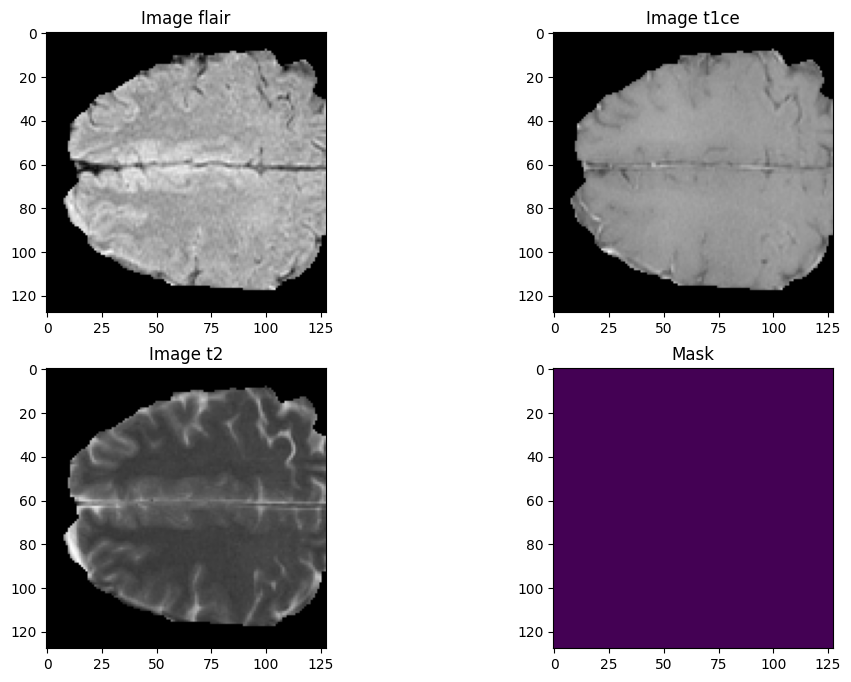

In [5]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [6]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Multiply, Add, UpSampling3D, Activation, Lambda
from keras import backend as K
import tensorflow as tf

kernel_initializer = 'he_uniform'

# Helper function to repeat elements
def repeat_elem(tensor, rep):
    return Lambda(lambda x: K.repeat_elements(x, rep, axis=4))(tensor)

# 3D Gating Signal
def gating_signal_3d(input, out_size, batch_norm=False):
    x = Conv3D(out_size, (1, 1, 1), padding='same')(input)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# 3D Attention Block
def attention_block_3d(x, gating, inter_shape):
    shape_x = K.int_shape(x)  # (batch, D, H, W, C)
    shape_g = K.int_shape(gating)  # (batch, D, H, W, C)

    # theta_x with stride 2x2x2
    theta_x = Conv3D(inter_shape, (2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)
    
    # phi_g with 1x1x1 conv
    phi_g = Conv3D(inter_shape, (1, 1, 1), padding='same')(gating)
    
    # Upsample phi_g to match theta_x dimensions
    upsample_g = Conv3DTranspose(
        inter_shape, (3, 3, 3),
        strides=(shape_theta_x[1]//shape_g[1], shape_theta_x[2]//shape_g[2], shape_theta_x[3]//shape_g[3]),
        padding='same')(phi_g)

    # Combine signals
    concat_xg = Add()([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    
    # Attention weights
    psi = Conv3D(1, (1, 1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    
    # Upsample attention weights
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling3D(
        size=(shape_x[1]//shape_sigmoid[1], 
              shape_x[2]//shape_sigmoid[2],
              shape_x[3]//shape_sigmoid[3]))(sigmoid_xg)
    
    # Repeat attention across channels
    upsample_psi = repeat_elem(upsample_psi, shape_x[4])
    
    # Apply attention
    y = Multiply()([upsample_psi, x])
    
    # Final convolution
    result = Conv3D(shape_x[4], (1, 1, 1), padding='same')(y)
   # result_bn = BatchNormalization()(result)
    return result



In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Activation, MaxPool3D, UpSampling3D, Concatenate, Add

def conv_block_3d(inputs, out_ch, rate=1):
    x = Conv3D(out_ch, 3, padding="same", dilation_rate=rate)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def RSU_L_3d(inputs, out_ch, int_ch, num_layers, rate=2):
    x = conv_block_3d(inputs, out_ch)
    init_feats = x

    skip = []
    x = conv_block_3d(x, int_ch)
    skip.append(x)

    for i in range(num_layers - 2):
        x = MaxPool3D((2, 2, 2))(x)
        x = conv_block_3d(x, int_ch)
        skip.append(x)

    x = conv_block_3d(x, int_ch, rate=rate)
    skip.reverse()

    x = Concatenate()([x, skip[0]])
    x = conv_block_3d(x, int_ch)

    for i in range(num_layers - 3):
        x = UpSampling3D(size=(2, 2, 2))(x)
        x = Concatenate()([x, skip[i + 1]])
        x = conv_block_3d(x, int_ch)

    x = UpSampling3D(size=(2, 2, 2))(x)
    x = Concatenate()([x, skip[-1]])
    x = conv_block_3d(x, out_ch)

    x = Add()([x, init_feats])
    return x

def RSU_4F_3d(inputs, out_ch, int_ch):
    x0 = conv_block_3d(inputs, out_ch, rate=1)

    x1 = conv_block_3d(x0, int_ch, rate=1)
    x2 = conv_block_3d(x1, int_ch, rate=2)
    x3 = conv_block_3d(x2, int_ch, rate=4)

    x4 = conv_block_3d(x3, int_ch, rate=8)

    x = Concatenate()([x4, x3])
    x = conv_block_3d(x, int_ch, rate=4)

    x = Concatenate()([x, x2])
    x = conv_block_3d(x, int_ch, rate=2)

    x = Concatenate()([x, x1])
    x = conv_block_3d(x, out_ch, rate=1)

    x = Add()([x, x0])
    return x

def u2net_3d(input_shape, out_ch, int_ch, num_classes=1):
    inputs = Input(input_shape)
    s0 = inputs

    s1 = RSU_L_3d(s0, out_ch[0], int_ch[0], 7)
    p1 = MaxPool3D((2, 2, 2))(s1)

    s2 = RSU_L_3d(p1, out_ch[1], int_ch[1], 6)
    p2 = MaxPool3D((2, 2, 2))(s2)

    s3 = RSU_L_3d(p2, out_ch[2], int_ch[2], 5)
    p3 = MaxPool3D((2, 2, 2))(s3)

    s4 = RSU_L_3d(p3, out_ch[3], int_ch[3], 4)
    p4 = MaxPool3D((2, 2, 2))(s4)

    s5 = RSU_4F_3d(p4, out_ch[4], int_ch[4])
    p5 = MaxPool3D((2, 2, 2))(s5)

    b1 = RSU_4F_3d(p5, out_ch[5], int_ch[5])
    b2 = UpSampling3D(size=(2, 2, 2))(b1)

    d1 = Concatenate()([b2, s5])
    d1 = RSU_4F_3d(d1, out_ch[6], int_ch[6])
    u1 = UpSampling3D(size=(2, 2, 2))(d1)

    d2 = Concatenate()([u1, s4])
    d2 = RSU_L_3d(d2, out_ch[7], int_ch[7], 4)
    u2 = UpSampling3D(size=(2, 2, 2))(d2)

    d3 = Concatenate()([u2, s3])
    d3 = RSU_L_3d(d3, out_ch[8], int_ch[8], 5)
    u3 = UpSampling3D(size=(2, 2, 2))(d3)

    d4 = Concatenate()([u3, s2])
    d4 = RSU_L_3d(d4, out_ch[9], int_ch[9], 6)
    u4 = UpSampling3D(size=(2, 2, 2))(d4)

    d5 = Concatenate()([u4, s1])
    d5 = RSU_L_3d(d5, out_ch[10], int_ch[10], 7)

    """ Side Outputs """
    y1 = Conv3D(num_classes, 3, padding="same")(d5)

    y2 = Conv3D(num_classes, 3, padding="same")(d4)
    y2 = UpSampling3D(size=(2, 2, 2))(y2)

    y3 = Conv3D(num_classes, 3, padding="same")(d3)
    y3 = UpSampling3D(size=(4, 4, 4))(y3)

    y4 = Conv3D(num_classes, 3, padding="same")(d2)
    y4 = UpSampling3D(size=(8, 8, 8))(y4)

    y5 = Conv3D(num_classes, 3, padding="same")(d1)
    y5 = UpSampling3D(size=(16, 16, 16))(y5)
    
    y6 = Conv3D(num_classes, 3, padding="same")(b1)
    y6 = UpSampling3D(size=(32, 32, 32))(y6)

    y0 = Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = Conv3D(num_classes, 3, padding="same")(y0)

    # Final activation
    y0 = Activation("softmax", name = 'main_output')(y0)
    y1 = Activation("softmax")(y1)
    y2 = Activation("softmax")(y2)
    y3 = Activation("softmax")(y3)
    y4 = Activation("softmax")(y4)
    y5 = Activation("softmax")(y5)
    y6 = Activation("softmax")(y6)

    model = tf.keras.models.Model(inputs, outputs=[y0, y1, y2, y3, y4, y5, y6])
    return model

def build_u2net_3d(input_shape, num_classes=4):
    out_ch = [32, 64, 128, 256, 256, 256, 256, 128, 64, 32, 16]
    int_ch = [16, 16, 32, 64, 128, 128, 128, 64, 32, 16, 8]
    return u2net_3d(input_shape, out_ch, int_ch, num_classes)


In [8]:
# Input shape: (Depth, Height, Width, Channels)
input_shape = (128, 128, 64, 3)  # Adjust dimensions based on your data

# Number of segmentation classes
num_classes = 4  # BraTS: background, edema, enhancing tumor, non-enhancing tumor

In [9]:
model = build_u2net_3d(input_shape=input_shape, num_classes=num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 64  2624        ['input_1[0][0]']                
                                , 32)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  128        ['conv3d[0][0]']                 
 alization)                     , 32)                                                         

In [10]:
import os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

In [11]:
train_img_dir = "Downloads/archive_2/input/output_data/train/images/"
train_mask_dir = "Downloads/archive_2/input/output_data/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)


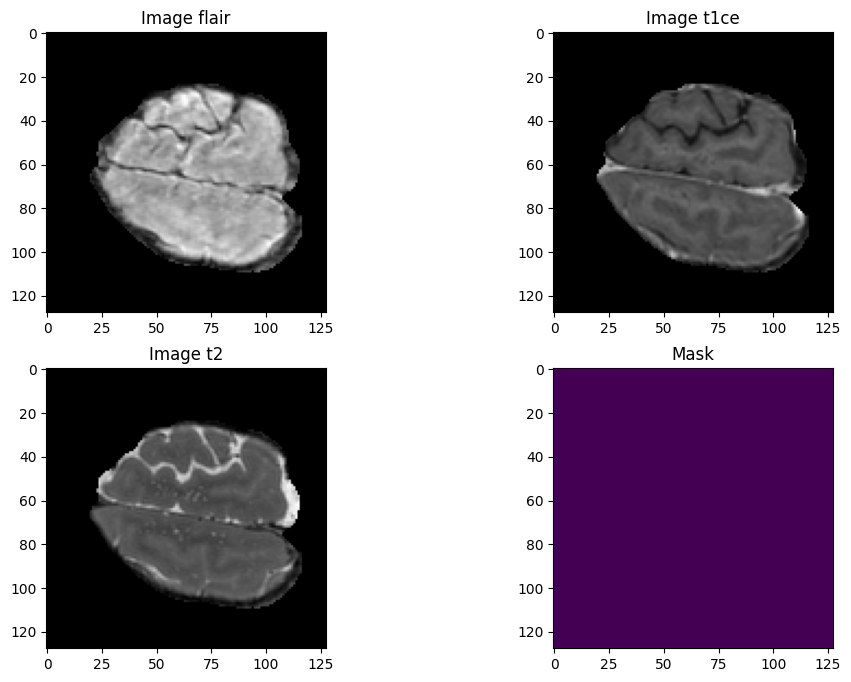

In [12]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
#Defining the image generators for training and validation

train_img_dir = "Downloads/archive_2/input/output_data/train/images/"
train_mask_dir = "Downloads/archive_2/input/output_data/train/masks/"

val_img_dir = "Downloads/archive_2/input/output_data/val/images/"
val_mask_dir = "Downloads/archive_2/input/output_data/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [14]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


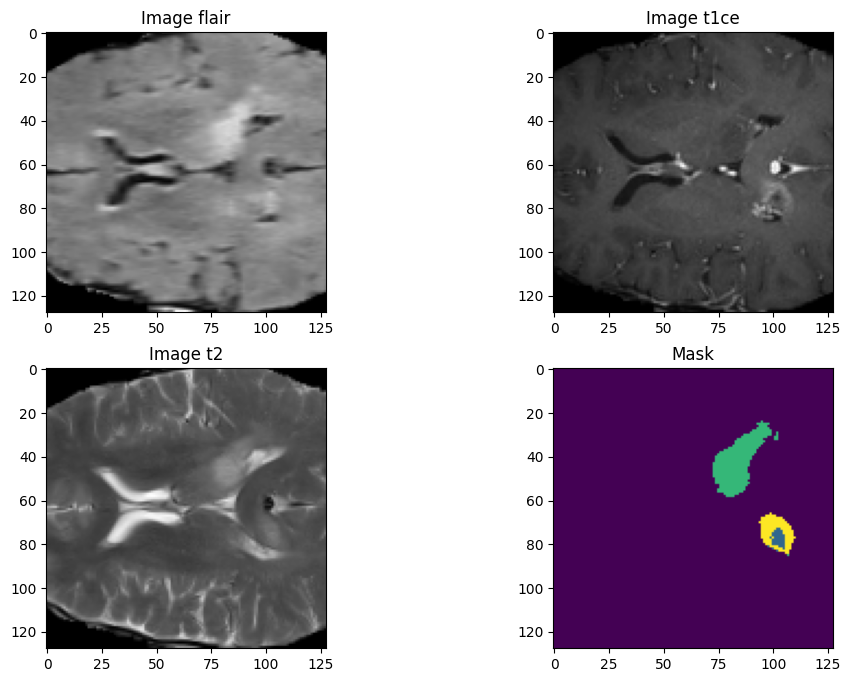

In [16]:
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Dice coefficient for multi-class segmentation.
    y_true: Ground truth (batch_size, height, width, num_classes)
    y_pred: Predicted probabilities (batch_size, height, width, num_classes)
    smooth: Smoothing factor to avoid division by zero.
    """
    class_num = 4  # Fixed number of classes
    total_loss = 0.0

    for i in range(class_num):
        y_true_f = K.flatten(y_true[..., i])  # Flattening the ground truth for class i
        y_pred_f = K.flatten(y_pred[..., i])  # Flattening the predictions for class i
        intersection = K.sum(y_true_f * y_pred_f)  # Compute the intersection
        loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_loss += loss

    return total_loss / class_num  # Return the average Dice coefficient

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [18]:
#wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
#
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

#import tensorflow as tf
#from tensorflow.keras import backend as K

#def focal_loss(gamma=2.0, alpha=0.25):
#    def focal_loss_fn(y_true, y_pred):
        # Clip predictions to prevent log(0) or log(1)
#        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        
        # Calculate cross-entropy
#        cross_entropy = -y_true * K.log(y_pred)
        
        # Calculate the focal loss
#        loss = alpha * K.pow(1.0 - y_pred, gamma) * cross_entropy
        
        # Sum over classes and average over batch
#        return K.sum(loss, axis=-1)
    
#   return focal_loss_fn

metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [19]:
#Fit the model 
#import segmentation_models_3D as sm
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "Downloads/archive_2/model_segmentation/u2net_3d_150epoch.hdf5",  # Save path
    monitor="val_main_output_dice_coef",  # Monitor validation dice coefficient
    save_best_only=True,  # Save only the best model
    save_weights_only=False,  # Save the full model (not just weights)
    mode="max",  # Maximize validation accuracy
    verbose=1  # Print when the model is saved
)


model = build_u2net_3d((128, 128, 64, 3), num_classes=4)

model.compile(
    optimizer=optim,
    loss='categorical_crossentropy',
    loss_weights=[1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    metrics=metrics 
)


In [20]:
from keras import backend as K


In [21]:
class MainOutputLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch + 1} - Main Output Metrics:")
        
        # Print training metrics
        print("Train:")
        for key in sorted(logs.keys()):
            if key.startswith("main_output") and not key.startswith("val_"):
                print(f"  {key}: {logs[key]:.4f}")

        # Print validation metrics
        print("Validation:")
        for key in sorted(logs.keys()):
            if key.startswith("val_main_output"):
                print(f"  {key}: {logs[key]:.4f}")

In [22]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=150,
          verbose=0,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[checkpoint_cb, MainOutputLogger()],
          )




Epoch 1: val_main_output_dice_coef improved from -inf to 0.43061, saving model to Downloads/archive_2/model_segmentation\u2net_3d_150epoch.hdf5

Epoch 1 - Main Output Metrics:
Train:
  main_output_accuracy: 0.9616
  main_output_dice_coef: 0.4674
  main_output_loss: 0.1237
  main_output_mean_io_u: 0.3750
  main_output_precision: 0.9672
  main_output_sensitivity: 0.9569
  main_output_specificity: 0.9896
Validation:
  val_main_output_accuracy: 0.9601
  val_main_output_dice_coef: 0.4306
  val_main_output_loss: 0.1325
  val_main_output_mean_io_u: 0.3750
  val_main_output_precision: 0.9625
  val_main_output_sensitivity: 0.9583
  val_main_output_specificity: 0.9876

Epoch 2: val_main_output_dice_coef improved from 0.43061 to 0.58660, saving model to Downloads/archive_2/model_segmentation\u2net_3d_150epoch.hdf5

Epoch 2 - Main Output Metrics:
Train:
  main_output_accuracy: 0.9767
  main_output_dice_coef: 0.5696
  main_output_loss: 0.0683
  main_output_mean_io_u: 0.3753
  main_output_precision

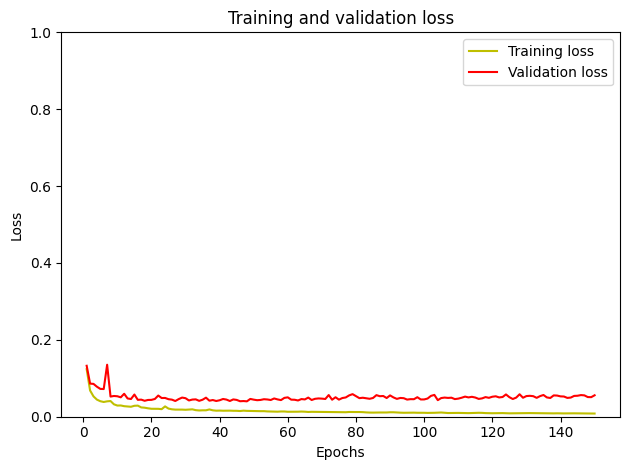

In [25]:
loss = history.history['main_output_loss']
val_loss = history.history['val_main_output_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

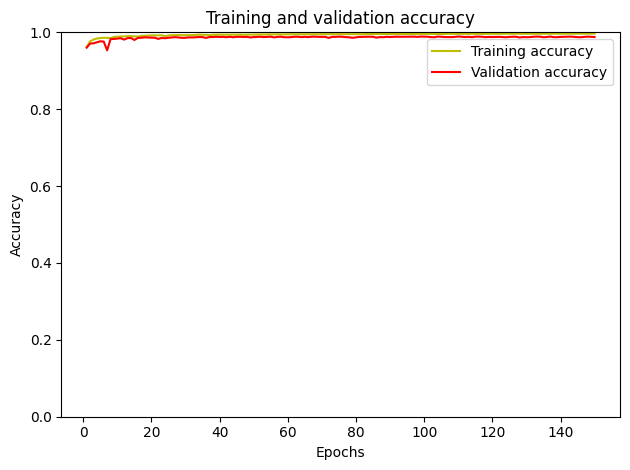

In [26]:
acc = history.history['main_output_accuracy']
val_acc = history.history['val_main_output_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

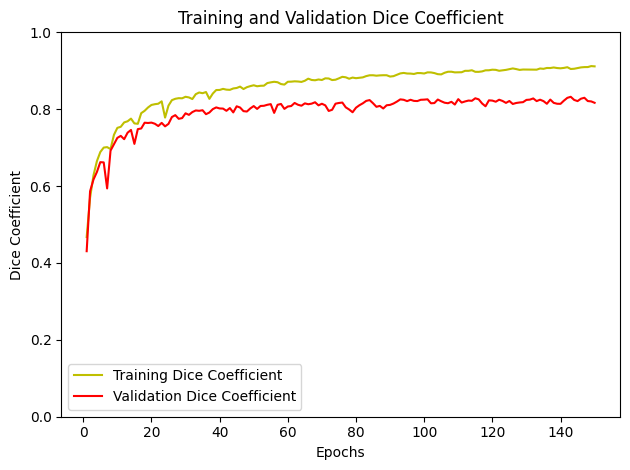

In [27]:
dice = history.history['main_output_dice_coef']
val_dice = history.history['val_main_output_dice_coef']

epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, 'y', label='Training Dice Coefficient')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


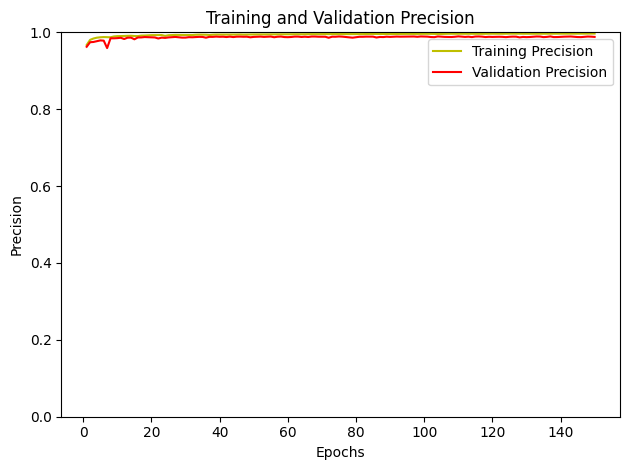

In [28]:
precision = history.history['main_output_precision']
val_precision = history.history['val_main_output_precision']
epochs = range(1, len(precision) + 1)
plt.plot(epochs, precision, 'y', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()



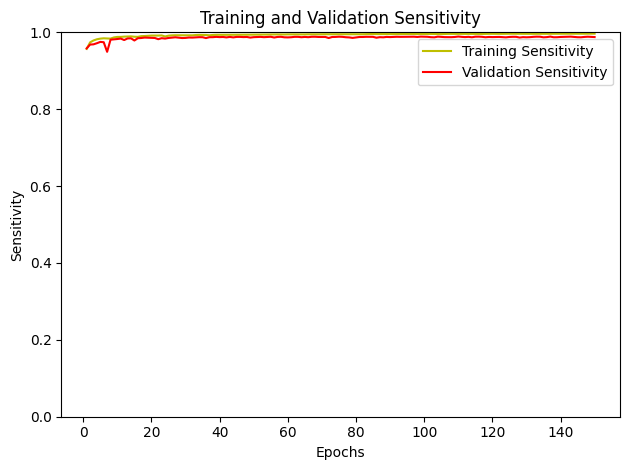

In [31]:
sensitivity = history.history['main_output_sensitivity']
val_sensitivity = history.history['val_main_output_sensitivity']
epochs = range(1, len(sensitivity) + 1)
plt.plot(epochs, sensitivity, 'y', label='Training Sensitivity')
plt.plot(epochs, val_sensitivity, 'r', label='Validation Sensitivity')
plt.title('Training and Validation Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()




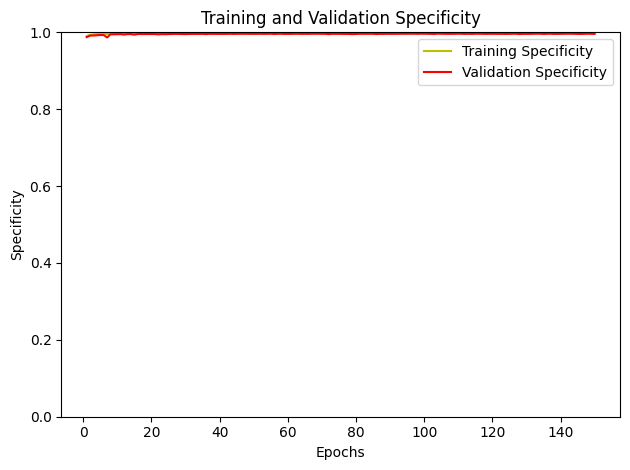

In [34]:
specificity = history.history['main_output_specificity']
val_specificity = history.history['val_main_output_specificity']
epochs = range(1, len(specificity) + 1)
plt.plot(epochs, specificity, 'y', label='Training Specificity')
plt.plot(epochs, val_specificity, 'r', label='Validation Specificity')
plt.title('Training and Validation Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


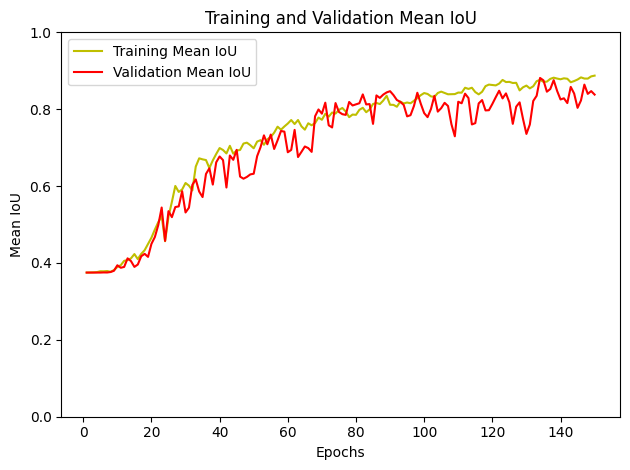

In [33]:
mean_iou = history.history['main_output_mean_io_u']
val_mean_iou = history.history['val_main_output_mean_io_u']
epochs = range(1, len(mean_iou) + 1)
plt.plot(epochs, mean_iou, 'y', label='Training Mean IoU')
plt.plot(epochs, val_mean_iou, 'r', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()




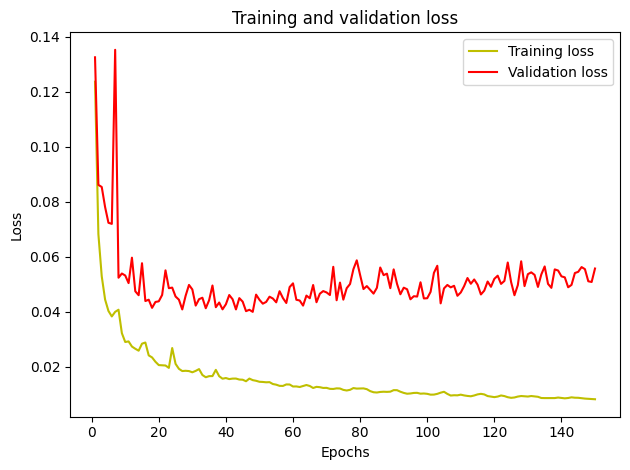

In [35]:
loss = history.history['main_output_loss']
val_loss = history.history['val_main_output_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


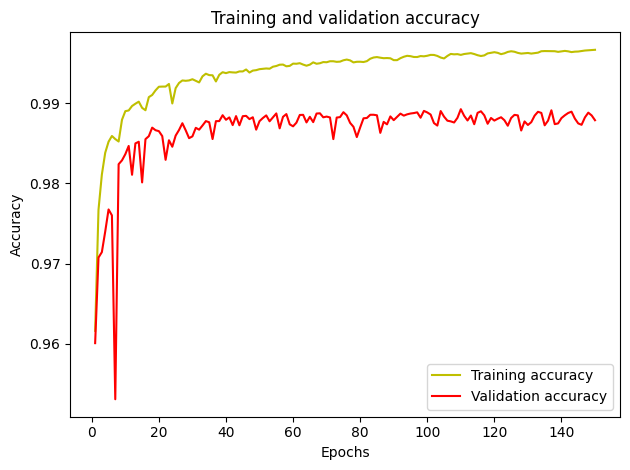

In [37]:
acc = history.history['main_output_accuracy']
val_acc = history.history['val_main_output_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


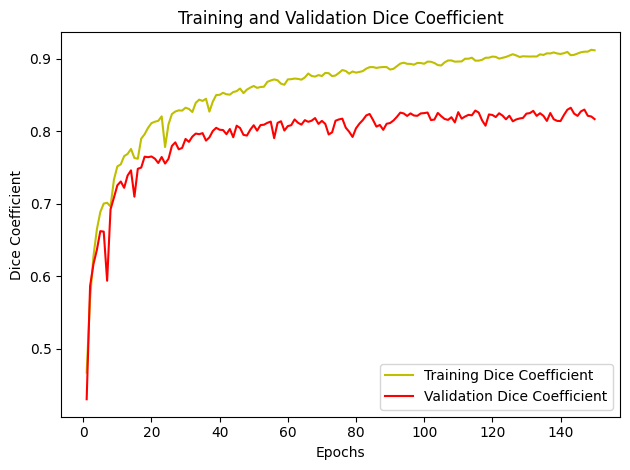

In [38]:
dice = history.history['main_output_dice_coef']
val_dice = history.history['val_main_output_dice_coef']

epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, 'y', label='Training Dice Coefficient')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.tight_layout()
plt.show()


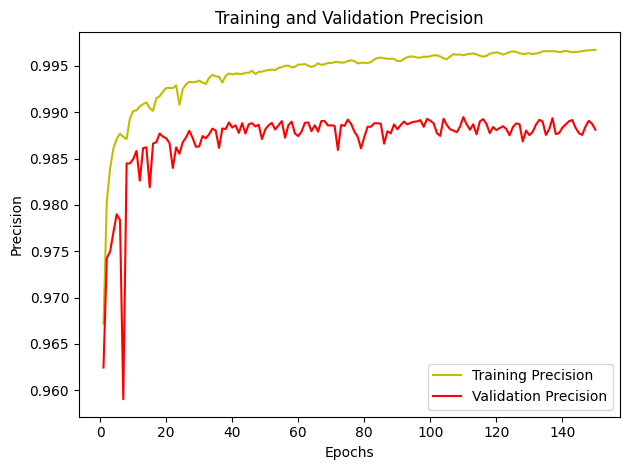

In [40]:
precision = history.history['main_output_precision']
val_precision = history.history['val_main_output_precision']
epochs = range(1, len(precision) + 1)
plt.plot(epochs, precision, 'y', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

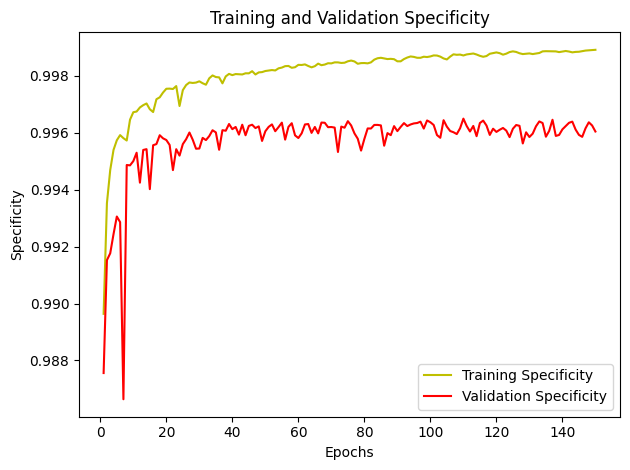

In [41]:
specificity = history.history['main_output_specificity']
val_specificity = history.history['val_main_output_specificity']
epochs = range(1, len(specificity) + 1)
plt.plot(epochs, specificity, 'y', label='Training Specificity')
plt.plot(epochs, val_specificity, 'r', label='Validation Specificity')
plt.title('Training and Validation Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')

plt.legend()
plt.tight_layout()
plt.show()

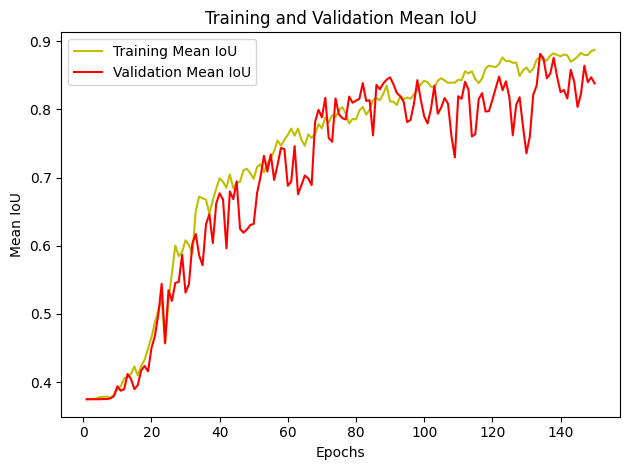

In [42]:
mean_iou = history.history['main_output_mean_io_u']
val_mean_iou = history.history['val_main_output_mean_io_u']
epochs = range(1, len(mean_iou) + 1)
plt.plot(epochs, mean_iou, 'y', label='Training Mean IoU')
plt.plot(epochs, val_mean_iou, 'r', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.tight_layout()
plt.show()


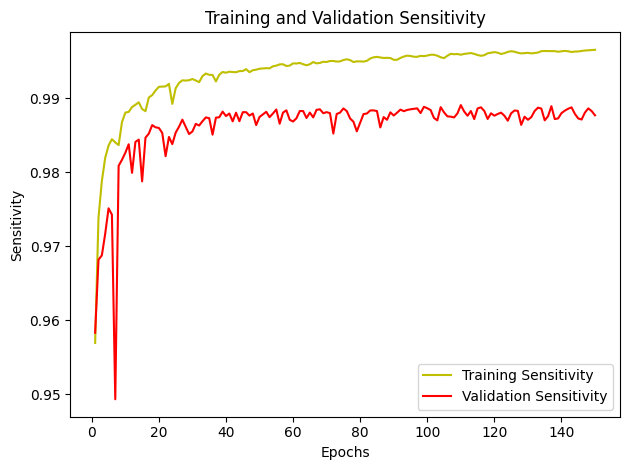

In [44]:
sensitivity = history.history['main_output_sensitivity']
val_sensitivity = history.history['val_main_output_sensitivity']
epochs = range(1, len(sensitivity) + 1)
plt.plot(epochs, sensitivity, 'y', label='Training Sensitivity')
plt.plot(epochs, val_sensitivity, 'r', label='Validation Sensitivity')
plt.title('Training and Validation Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend()
plt.tight_layout()
plt.show()



In [30]:
import os
print(os.getcwd())


C:\Users\User


In [76]:
#model.save('Downloads/archive_2/model_segmentation/brats_2021_200epoch_residual2.hdf5')


In [53]:
from keras.models import load_model
my_model = load_model('Downloads/archive_2/model_segmentation/u2net_3d_150epoch.hdf5', compile = False)

In [68]:
#Prediction on a few test images, one at a time

img_num = 221

test_img = np.load("Downloads/archive_2/input/output_data/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("Downloads/archive_2/input/output_data/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
#test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
test_prediction_argmax = np.argmax(test_prediction, axis=-1)[0]  # shape: (H, W, D)



1/1 [==============================] - 0s 157ms/step


In [69]:
test_img_input.shape



(1, 128, 128, 64, 3)

In [70]:
test_prediction_argmax.shape



(1, 128, 128, 64)

In [73]:
test_prediction_argmax = test_prediction_argmax[0]  # shape: (128, 128, 64)



In [74]:
test_prediction_argmax.shape



(128, 128, 64)

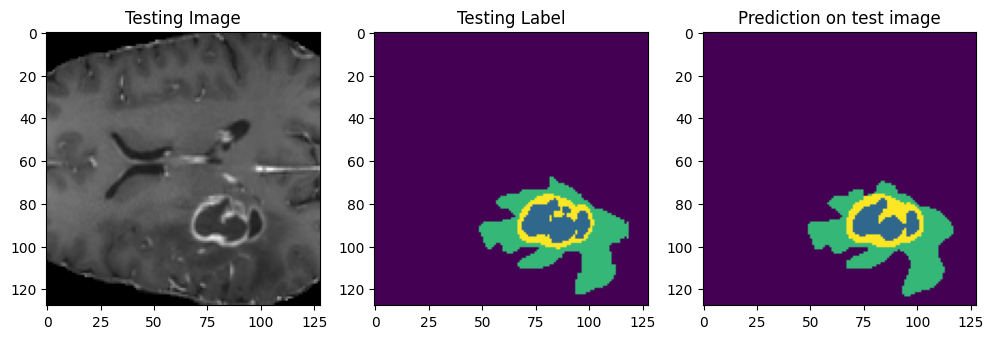

In [81]:
#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 12
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [78]:
print("Prediction shape:", test_prediction_argmax.shape)
print("Unique values in prediction slice:", np.unique(test_prediction_argmax[:, :, n_slice]))


Prediction shape: (128, 128, 64)
Unique values in prediction slice: [0 1 2 3]


In [79]:
#Prediction on a few test images, one at a time

img_num = 329

test_img = np.load("Downloads/archive_2/input/output_data/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("Downloads/archive_2/input/output_data/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
#test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
test_prediction_argmax = np.argmax(test_prediction, axis=-1)[0] 
test_prediction_argmax = test_prediction_argmax[0]

1/1 [==============================] - 0s 164ms/step


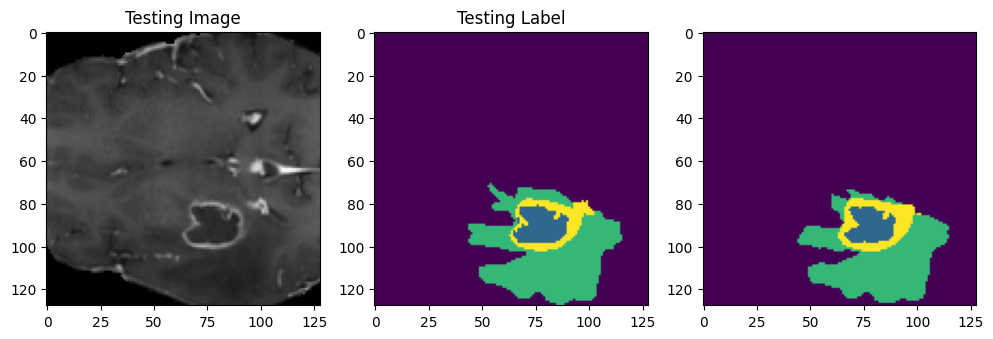

In [80]:
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 1
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
#plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()